# Learning notebook
To use this notebook you don't need to interact with any code, just run cells in order and a graphical user interface will pop-up showcasing the parameters for each step.

In [1]:
import sys
sys.path.append('../')
import ipywidgets as widgets
from IPython.display import display
import stackview
import datetime
import torch
import numpy as np
import imageio
import os

import ailoc.lunar
import ailoc.deeploc
import ailoc.common
import ailoc.simulation
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
ailoc.common.setup_seed(42)

%matplotlib inline

## 1. Set the necessary parameters to train the network, mainly about the training data simulation

In [2]:
learn_param_widget = ailoc.common.SetLearnParamWidget()
learn_param_widget.display_notebook_gui()

SelectFilesButton(description='Optional: select the experiment file to estimate background range', icon='squar…

SelectFilesButton(description='Select the calibration file', icon='square-o', layout=Layout(height='80px', wid…

Button(description='Load from calib', style=ButtonStyle())

Label(value='PSF parameters', style=LabelStyle(font_weight='bold'))

SetPSFParamWidget(children=(BoundedFloatText(value=1.5, description='NA:', layout=Layout(grid_area='widget001'…

Label(value='Camera parameters', style=LabelStyle(font_weight='bold'))

Dropdown(description='CameraType:', index=1, options=('Idea Camera', 'sCMOS', 'EMCCD'), value='sCMOS')

GridspecLayout(children=(sCMOSParamWidget(children=(BoundedFloatText(value=0.81, description='QE:', layout=Lay…

SetSamplerParamWidget(children=(Label(value='Sampler parameters', layout=Layout(grid_area='widget001'), style=…

Button(description='OK', style=ButtonStyle())

Output()

## Optional: using the provided experimental image to estimate the background range

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
read first (15176, 264, 268) images
experimental images provided, automatically adjust training parameters


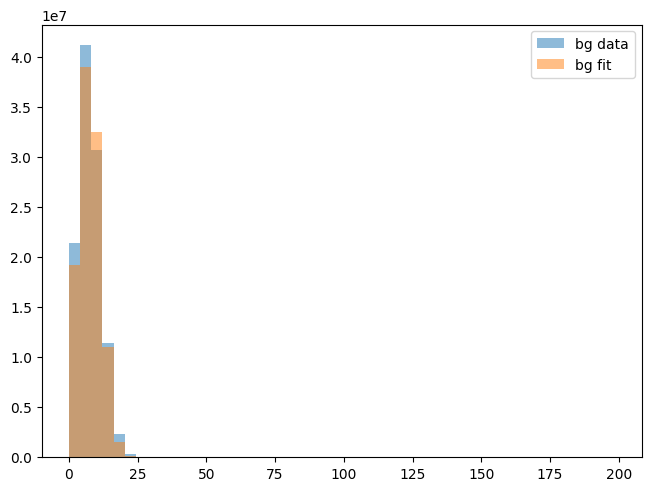

Adjusted bg_range:  (0.0, 15.500398635864258)
Check the parameters:
---------------------------------------------------------------------- learning parameters ----------------------------------------------------------------------------------------------------
na: 1.5
wavelength: 670.0
refmed: 1.406
refcov: 1.524
refimm: 1.518
objstage0: -1400.0
zemit0: 1296.7061923583663
pixel_size_xy: (108.0, 108.0)
otf_rescale_xy: (0.5, 0.5)
npupil: 64
psf_size: 31
zernike_mode:
 [[ 2.  2.  3.  3.  4.  3.  3.  4.  4.  5.  5.  6.  4.  4.  5.  5.  6.  6.
   7.  7.  8.]
 [-2.  2. -1.  1.  0. -3.  3. -2.  2. -1.  1.  0. -4.  4. -3.  3. -2.  2.
   1. -1.  0.]]
zernike_coef:
 [ 57.3   9.4 -29.3  11.2  31.7  -7.1  -6.2 -25.8 -17.3   9.2  13.3  39.7
  -2.1   3.9   2.9  -2.2  13.1  -1.    6.1   3.2  27.5]
camera_type: scmos
qe: 0.81
spurious_charge: 0.002
read_noise_sigma: 1.6
e_per_adu: 0.47
baseline: 100.0
local_context: True
temporal_attn: True
robust_training: True
context_size: 8
train_size: 128
num_em_a

In [3]:
if learn_param_widget.exp_file_receiver.files is not None:
    experimental_images = ailoc.common.read_first_size_gb_tiff(learn_param_widget.exp_file_receiver.files, 2)
    camera_calib = ailoc.simulation.instantiate_camera(learn_param_widget.params_dict['camera_params_dict'])
    experimental_images_photon = ailoc.common.cpu(camera_calib.backward(torch.tensor(experimental_images.astype(np.float32))))
    print('experimental images provided, automatically adjust training parameters')
    learn_param_widget.params_dict['sampler_params_dict']['bg_range'] = ailoc.common.get_bg_stats_gauss(experimental_images_photon, percentile=10,
                                                                      plot=True)
    print('Adjusted bg_range: ', learn_param_widget.params_dict['sampler_params_dict']['bg_range'])
    
print('Check the parameters:')
ailoc.common.print_learning_params(learn_param_widget.params_dict['psf_params_dict'], 
                                   learn_param_widget.params_dict['camera_params_dict'],
                                   learn_param_widget.params_dict['sampler_params_dict'])

## 2. Initialize the DL model

In [4]:
# loc_model = ailoc.deeploc.DeepLoc(learn_param_widget.params_dict['psf_params_dict'],
#                                   learn_param_widget.params_dict['camera_params_dict'],
#                                   learn_param_widget.params_dict['sampler_params_dict'])

loc_model = ailoc.lunar.Lunar_LocLearning(learn_param_widget.params_dict['psf_params_dict'],
                                  learn_param_widget.params_dict['camera_params_dict'],
                                  learn_param_widget.params_dict['sampler_params_dict'])

# loc_model = ailoc.lunar.Lunar_SyncLearning(learn_param_widget.params_dict['psf_params_dict'],
#                                   learn_param_widget.params_dict['camera_params_dict'],
#                                   learn_param_widget.params_dict['sampler_params_dict'])

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Testing network parameters and multiply-accumulate operations (MACs)
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.UpsamplingNearest2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
Params:1.472M, MACs:31.550G, (input shape:torch.Size([1, 14, 64, 64]))
Average forward time: 0.0066 s


## 3. Check the PSF model used for training data simulation 

checking PSF...


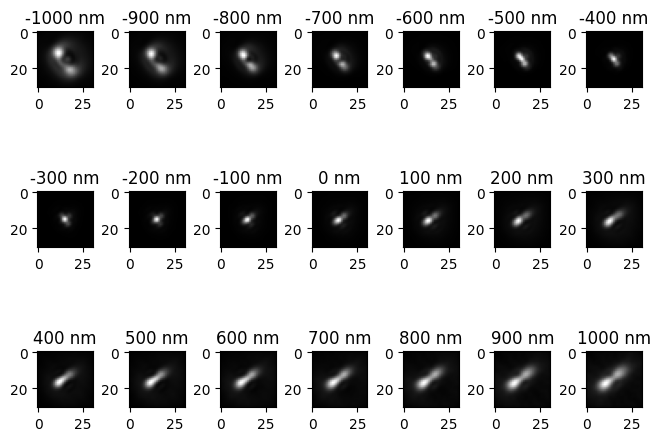

checking training data...


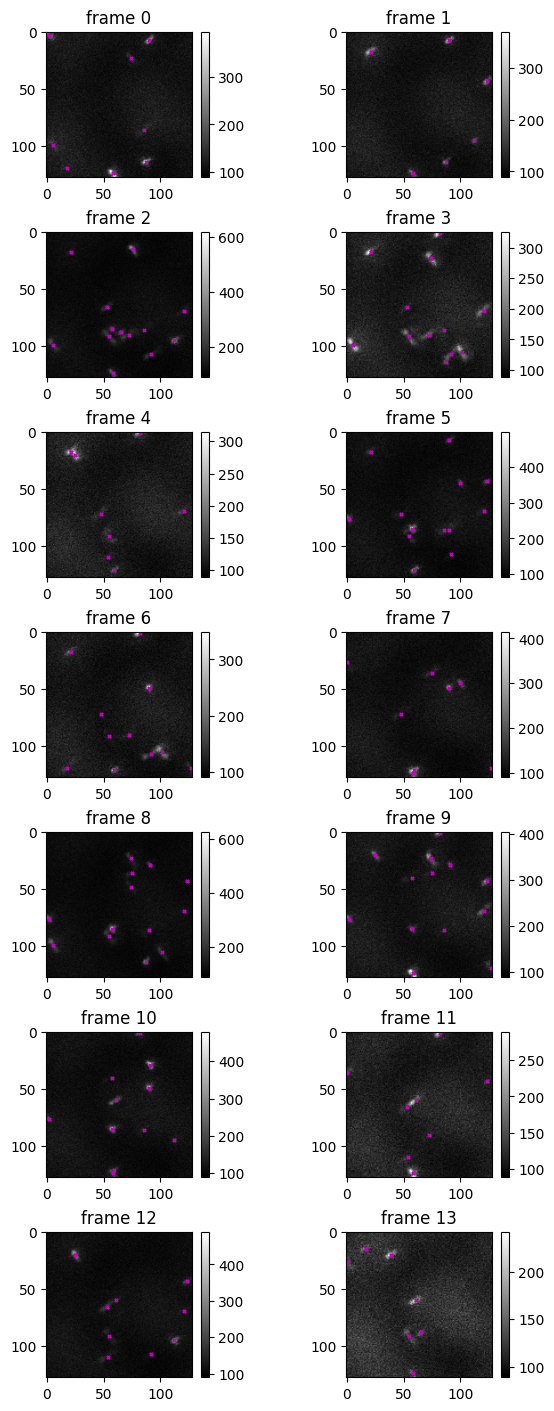

In [5]:
loc_model.check_training_psf()
loc_model.check_training_data()

## 4. Simulate an evaluation dataset to track the network performance

In [6]:
loc_model.build_evaluation_dataset(napari_plot=False)
display(stackview.slice(loc_model.evaluation_dataset['data'][:,0], colormap='turbo', continuous_update=True))

building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 7967 target molecules, time cost: 7.08s


## 5. Your are ready to go training the network!

In [7]:
# file_name = '../results/' + datetime.datetime.now().strftime('%Y-%m-%d-%H') + 'DeepLoc.pt'
# loc_model.online_train(
#         batch_size=2,
#         max_iterations=40000,
#         eval_freq=500,
#         file_name=file_name
#     )

file_name = '../results/' + datetime.datetime.now().strftime('%Y-%m-%d-%H') + 'LUNAR_LL.pt'
loc_model.online_train(
        batch_size=2,
        max_iterations=40000,
        eval_freq=500,
        file_name=file_name
    )

# file_name = '../results/' + datetime.datetime.now().strftime('%Y-%m-%d-%H') + 'LUNAR_SL.pt'
# loc_model.online_train(
#         batch_size=1,
#         max_iterations=40000,
#         eval_freq=1000,
#         file_name=file_name,
#         real_data=experimental_images,
#         num_sample=100,
#         wake_interval=2,
#         max_recon_psfs=5000,
#         online_build_eval_set=True,
#     )

Start training...
Iterations: 500/40000 || Loss: 402.90 || IterTime: 259.88 ms || ETA: 2.85 h || No recent performance record found
LUNAR instance saved to ../results/2024-12-31-15LUNAR_LL.pt
Iterations: 1000/40000 || Loss: 121.03 || IterTime: 257.98 ms || ETA: 2.79 h || No recent performance record found
LUNAR instance saved to ../results/2024-12-31-15LUNAR_LL.pt
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
evaluating...
FOV=[0, 13824, 0, 13824] nm, border=450, tolerance_xy=250, tolerance_z=500
pairing localizations on 800 images, ground truth: 6934, predictions: 4429, please waiting...
evaluating done! time cost: 3.34s
Iterations: 1500/40000 || Loss: 82.16 || IterTime: 258.11 ms || ETA: 2.76 h || SumProb: 9.24 || Eff_3D: 39.30 || Jaccard: 0.63 || Recall: 0.63 || Precision: 0.99 || RMSE_lat: 52.45 || RMSE_ax: 87.12
LUNAR instance s

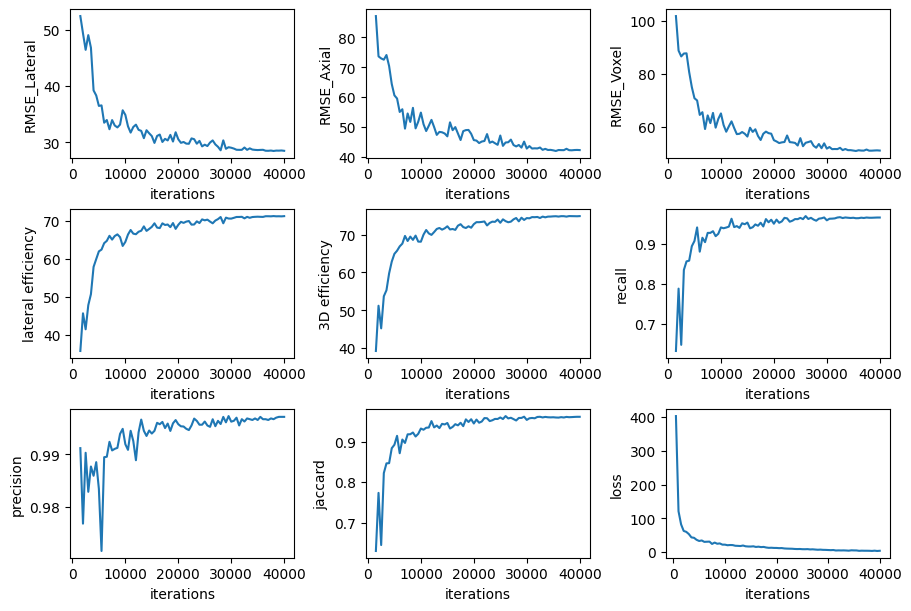

In [8]:
# plot evaluation performance during the localization learning
ailoc.common.plot_train_record(loc_model)

# # plot evaluation performance during the synchronized learning
# phase_record = ailoc.common.plot_synclearning_record(loc_model)
# # save the pupil changes during the learning
# imageio.mimsave('../results/' + os.path.split(file_name)[-1].split('.')[0] + '_phase.gif',
#                 phase_record,
#                 duration=200)